# Data Assignment - Arpeely
**Submitted by**: Ben Hevrony  
**Date**: September 18, 2022

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from us import states

with open('data_assignment.csv', newline='', encoding='utf8') as file:
    df = pd.read_csv(file, header=0, dtype={'postal_code': str}, parse_dates=['time'])

df['local_time'] = df.apply(
    lambda x: x['time'].astimezone(states.lookup(x['state_code']).time_zones[0]) if x['state_code'] is not np.nan else np.nan,
    axis=1)
df['local_hour'] = df.apply(
    lambda x: x['time'].astimezone(states.lookup(x['state_code']).time_zones[0]).hour if x['state_code'] is not np.nan else np.nan,
    axis=1)
df['device_type']=df['device_type'].str.replace('_',' ').str.title()

# 1. Characterization

## Metadata

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249232 entries, 0 to 249231
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   time                  249232 non-null  datetime64[ns, UTC]
 1   user_id               249232 non-null  object             
 2   domain                249222 non-null  object             
 3   url                   249232 non-null  object             
 4   ad_slot               249232 non-null  object             
 5   country               249232 non-null  object             
 6   postal_code           201974 non-null  object             
 7   state_code            240773 non-null  object             
 8   city                  236697 non-null  object             
 9   user_agent            249194 non-null  object             
 10  cookie_age_seconds    249232 non-null  int64              
 11  detected_language     249033 non-null  object       

As can be seen in the printout above, the dataset has roughly 250k records and 28 columns (after creation of local time discused below). The printout also provides data types which are clues regarding the data in each column. It should be noted that properly importing the CSV file allowed the time column to be a pandas datetime object which is important for its methods in the next section.

## Local Time

As a first step towards analyzing the data I chose to look at correlations with regards to local time. The US Python library has a useful lookup tool that includes timezones which allows for easy conversion of UTC times to local times using state codes. Some states lie in two timezones, the first time zone was taken as there is little difference between adjacent timezones. The hour of day was also extracted in this process into a separate column. There are no records which reside in a country other than US; therefore, for the purposes of this dataset the US Python library is sufficient. Note that the consequences of this is that the data is heavily biased towards users from the US, and any conclusion drawn must take this into account.


The target is to analyze impressions and conversions as functions of hour of day. The first step is to slice the dataframe into the relevant columns (local hour and conversion) and cast data types to more easily handle the columns later on. Records containing a np.nan (or NA) object in the time column were ones which had no state code associated with the user and therefore could provide no insight with respect to daily time distributions. Records with an NA under conversion are ambiguous and assumed to have no data associated with them. The above discussed classes of records are to be removed from consideration. It should be noted, however, that in doing so approximately 8500 records would be purged due to the former condition and approximately 120k due to the latter.
The former condition is negligible in terms of its effect on skewing results. The latter, however, is far from negligible in size and consequently in its ultimate effect on skewin the results. In cases of such ambiguity, one may decide to simulate best/worst case scenarios and estimate the actual results somewhere in between. For this reason, only NA records in local time will be purged and NA records in conversion will be assumed to have a value of 0 to simulate the worst case scenario.

In [3]:
filt = df['conversion'].isna() & (~df['state_code'].isna())
print(f'{len(df[filt])} records contain an NA value in the conversion column and a non-NA value in the state_code column.')
print(f'{len(df[df["state_code"].isna()])} records contain an NA value in the state_code column.')

120424 records contain an NA value in the conversion column and a non-NA value in the state_code column.
8459 records contain an NA value in the state_code column.


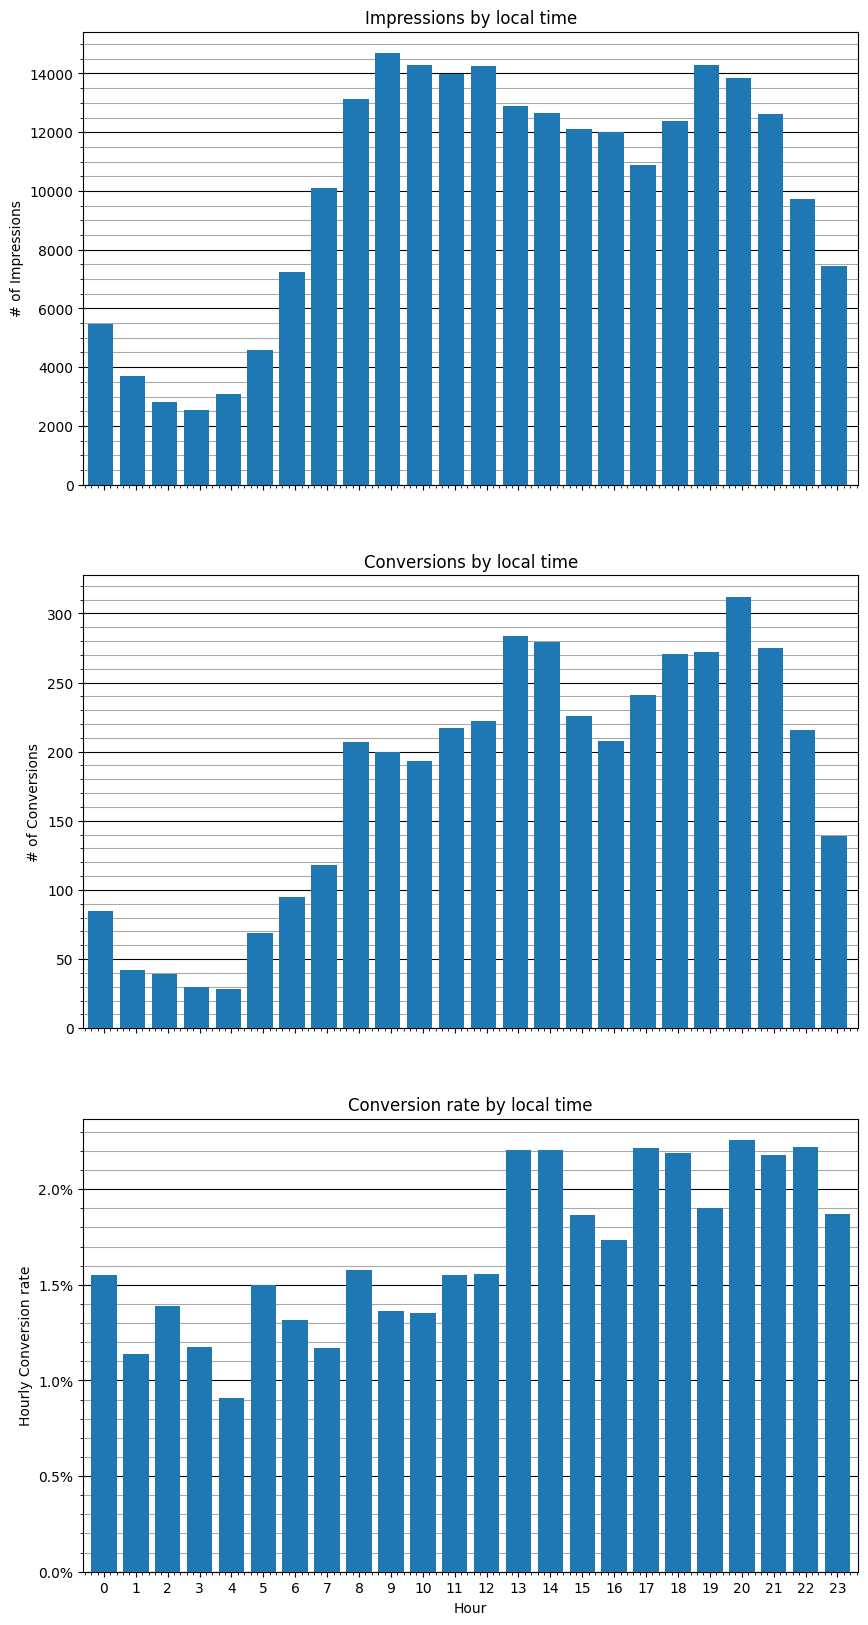

In [4]:
time_fig,time_ax = plt.subplots(3,1,sharex='col',figsize=(10,20));
time_conv = df[['local_hour','conversion']].dropna(subset=['local_hour']).fillna(0)
time_conv.astype(int,copy=False)


time_hist = time_conv['local_hour'].plot(zorder=3,kind='hist',bins=np.arange(-0.5,24.5,1),xticks=np.arange(0,24,1),rot=0,width=0.8,ax=time_ax[0])
time_hist.title.set_text('Impressions by local time')
time_hist.minorticks_on()
time_hist.set_xlabel('Hour')
time_hist.set_ylabel('# of Impressions')
time_hist.grid(which='minor',axis='y',color='DarkGray',zorder=0)
time_hist.grid(which='major',axis='y',color='k',zorder=0)



time_hist_conv = time_conv[time_conv['conversion'] == 1]['local_hour'].plot(zorder=3,kind='hist',bins=np.arange(-0.5,24.5,1),xticks=np.arange(0,24,1),rot=0,width=0.8,ax=time_ax[1])
time_hist_conv.title.set_text('Conversions by local time')
time_hist_conv.minorticks_on()
time_hist_conv.set_xlabel('Hour')
time_hist_conv.set_ylabel('# of Conversions')
time_hist_conv.grid(which='minor',axis='y',color='DarkGray',zorder=0)
time_hist_conv.grid(which='major',axis='y',color='k',zorder=0)



hourly_imps = time_conv['local_hour'].value_counts().sort_index()
hourly_conv = time_conv['local_hour'][time_conv['conversion']==1].value_counts().sort_index()

hour_totals = pd.concat([hourly_conv,hourly_imps],axis=1)
hour_totals.columns = ['Conversions','Impressions']
hour_totals['conversion_rate'] = hour_totals['Conversions']/hour_totals['Impressions']
conv_rate_bar = hour_totals['conversion_rate'].plot(kind='bar',xticks=np.arange(0,24,1),rot=0,width=0.8,zorder=3,ax=time_ax[2])
conv_rate_bar.title.set_text('Conversion rate by local time')
conv_rate_bar.minorticks_on()
conv_rate_bar.yaxis.set_major_formatter(ticker.PercentFormatter(1,decimals=1))
conv_rate_bar.set_xlabel('Hour')
conv_rate_bar.set_ylabel('Hourly Conversion rate')
conv_rate_bar.grid(which='minor',axis='y',color='DarkGray',zorder=0)
conv_rate_bar.grid(which='major',axis='y',color='k',zorder=0)

It is evident that most ad traffic occurs from the afternoon to the early hours of the night. Conversions follow a similar trend though a distinct feature manifests in this plot. It appears that for two hours in the afternoon (right around or just following lunch) there is an uptick in conversions, comparable in raw numbers and rates to the evening hours.

## Conversion by device type

In this case, the ambiguity of NA values under the conversion column is an obstacle yet again. The objective is to analyze this data under the same "worst case scenario" conditions.

In [5]:
dev_type = df[['device_type','conversion']].fillna(0)
dev_type['conversion'] = dev_type['conversion'].astype(int)
# dev_type.groupby('device_type').value_counts()
devices = dev_type.pivot_table(index='device_type',aggfunc={'conversion':[np.sum, len]})
devices.columns = ['Impressions','Conversions']
devices['conv_rate'] = np.round(devices['Conversions']/devices['Impressions'],4)
devices

,Impressions,Conversions,conv_rate
device_type,,,
Game Console,5,0,0.0000
Highend Phone,104663,2409,0.0230
Personal Computer,137445,1800,0.0131
Tablet,7119,159,0.0223


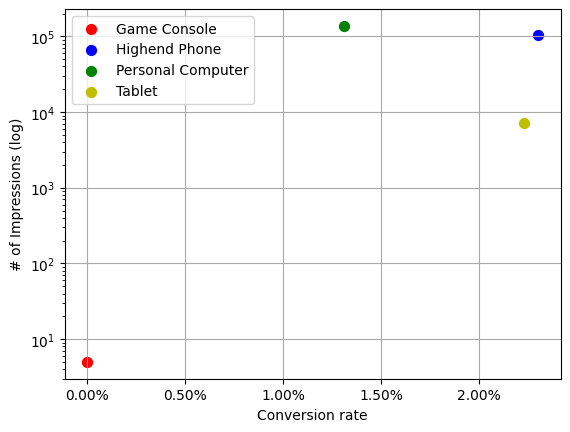

In [6]:
colors= {i:j for i,j in zip(devices.index,['r','b','g','y'])}
for i in devices.index:
    plt.scatter(x='conv_rate',y='Impressions',s=50,data=devices.loc[i],color =colors[i],label=i)
device_conv_scatter = plt.gca()
device_conv_scatter.set_yscale('log')
device_conv_scatter.xaxis.set_major_formatter(ticker.PercentFormatter(1,decimals=2))
device_conv_scatter.set_xlabel('Conversion rate')
device_conv_scatter.set_ylabel('# of Impressions (log)')
device_conv_scatter.grid(which='major',color='DarkGray',zorder=0)
device_conv_scatter.legend();


Clearly mobile devices, tablets or smartphones, are leading in terms of conversion rates. The sample size for tablets is lower (2 OoM) than that of highend phones but it is still robust. Conversely, data for game consoles is insignificant in volume and no meaningful conclusions can be drawn. Finally, PC users are most represented in terms of raw number of impressions but are the least likely to click-through based on the data (excluding consoles).

# 2. Click-Through Rate

To find the most predictive features for conversion, an absolute value of correlation between columns of the dataframe is useful. Categorical columns should be factorized to facilitate calculation of correlations. 

In [7]:
df[['fact_dev','fact_brand','fact_state','fact_city','fact_lang','fact_ua','fact_domain','fact_url','fact_ad']] = df[['device_type','device_brand','state_code','city','detected_language','user_agent','domain','url','ad_slot']].apply(lambda x: x.factorize()[0])

conv_corr = df.corr().abs()
conv_corr

,cookie_age_seconds,is_wifi,viewability,session_depth,bidded,bid,won_bid,feedback_bid,conversion,local_hour,fact_dev,fact_brand,fact_state,fact_city,fact_lang,fact_ua,fact_domain,fact_url,fact_ad
cookie_age_seconds,1.000000,0.094346,0.005963,0.099197,0.000976,0.030586,0.065373,0.025968,0.004324,0.006554,0.043164,0.024510,0.027047,0.015368,0.001216,0.052993,0.018888,0.010873,0.002864
is_wifi,0.094346,1.000000,0.000658,0.012658,0.051424,0.032165,0.054453,0.011664,0.008020,0.016043,0.270607,0.195886,0.011772,0.170583,0.008623,0.362903,0.085605,0.064658,0.039595
viewability,0.005963,0.000658,1.000000,0.036927,0.043073,0.073287,0.020655,0.055631,0.090426,0.020911,0.082286,0.035101,0.012592,0.017338,0.020615,0.017601,0.027894,0.008595,0.027871
session_depth,0.099197,0.012658,0.036927,1.000000,0.083939,0.035035,0.016615,0.018672,0.036384,0.012834,0.116518,0.074110,0.002633,0.006809,0.008193,0.023845,0.006330,0.113131,0.056204
bidded,0.000976,0.051424,0.043073,0.083939,1.000000,NaN,NaN,NaN,NaN,0.069373,0.071004,0.052884,0.008172,0.001165,0.039839,0.045709,0.206947,0.366266,0.353804
bid,0.030586,0.032165,0.073287,0.035035,NaN,1.000000,0.185908,0.307869,0.123856,0.005100,0.126538,0.072559,0.000125,0.004702,0.019231,0.042349,0.276751,0.179921,0.203599
won_bid,0.065373,0.054453,0.020655,0.016615,NaN,0.185908,1.000000,0.010454,0.246507,0.082107,0.042888,0.028191,0.006939,0.010779,0.009185,0.036606,0.111475,0.119438,0.109419
feedback_bid,0.025968,0.011664,0.055631,0.018672,NaN,0.307869,0.010454,1.000000,0.025365,0.014406,0.066684,0.037332,0.002992,0.001094,0.009809,0.010398,0.157888,0.094313,0.076925
conversion,0.004324,0.008020,0.090426,0.036384,NaN,0.123856,0.246507,0.025365,1.000000,0.019844,0.038010,0.012931,0.000950,0.002908,0.002941,0.003970,0.034873,0.065212,0.043405
local_hour,0.006554,0.016043,0.020911,0.012834,0.069373,0.005100,0.082107,0.014406,0.019844,1.000000,0.020969,0.012330,0.002629,0.010487,0.012974,0.002944,0.050562,0.070661,0.076778


In [8]:
conv_corr['conversion'].sort_values(ascending=False).dropna()

conversion            1.000000
won_bid               0.246507
bid                   0.123856
viewability           0.090426
fact_url              0.065212
fact_ad               0.043405
fact_dev              0.038010
session_depth         0.036384
fact_domain           0.034873
feedback_bid          0.025365
local_hour            0.019844
fact_brand            0.012931
is_wifi               0.008020
cookie_age_seconds    0.004324
fact_ua               0.003970
fact_lang             0.002941
fact_city             0.002908
fact_state            0.000950
Name: conversion, dtype: float64

Extraction of the conversion column in the correlation matrix, in descending order, yields the most predictive numerical features in the dataset. The first actual feature provided before the auction is closed is viewability, it is the strongest numerical predictor of click-through in this dataset, following it the URL and ad slot columns are next in line, and so forth. It is worth noting that several features are actually provided post-auction and are therefore not under consideration for predictors. 

# 3. Pre-bid Prediction

We first filter our records to ones for which we have auction data, that is ones on which we've placed a bid. Each URL and ad slot pair uses a single auction type exclusively, these should be analyzed seperately.

## Second Price Auction

In a second price auction the feedback is always the winning bid, this can be used to generate a distribution from which one can extract the probability of a bid winning for a given url/slot pair. Using frequencies of values in ranges the probability of a bid winning can be estimated.

## First Price Auction

In a first price auction the feedback changes based on the winning status of the auction.
The distribution would be based on the feedback such that the winning bid is taken as is if we were outbidded in the auction. Otherwise, if we won the auction, the feedback is the next highest bid. Therefore the feedback amount plus the minimum bid increment is the real winning bid. After the above described process is performed the distribution may be found in the same way as in second price auctions.